In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Some constants and default values

STBO = 5.67e-8 # W m-2 K-4

S0 = 1360. / 4 # W m-2
ALPHA = 0.3

PS = 1e5 # Pa

EMIS = 0.95 # surface emmisivity; global mean
TRANS = 0.28 # atmospheric transmitivity; 0.5 for a 'black' atmosphere; 0.28 as calculated from spectral models


def print_ts(TS, unit = "K", remark = ""):

    print(f"Surface Temperature = {TS:.2f} K; {remark}")

def outgoing_longwave_rad(TS, EMIS= EMIS, TRANS =TRANS):
    return 0.5* (1 + TRANS) * EMIS * STBO * TS**4 


# Level 1
## Solar radiation and earth's surface

In [3]:
def TS_surface_only(S0 = S0, ALPHA = ALPHA, EMIS = EMIS):
    TS =  (S0 * ( 1 - ALPHA ) / (EMIS * STBO))**0.25
    return TS

In [4]:
surface_emissivity = 1. # for a blackbody surface

print_ts(
TS_surface_only(S0=S0,
                ALPHA=ALPHA,
                EMIS= surface_emissivity
                )
        )

Surface Temperature = 254.54 K; 


In [5]:
surface_emissivity = 0.95 # typical global mean, from observations

print_ts(
TS_surface_only(S0=S0,
                ALPHA=ALPHA,
                EMIS= surface_emissivity
                )
        )

Surface Temperature = 257.82 K; 


# Level 2

## Let us add a black atmosphere

In [6]:
def TS_surface_w_black_atm(S0 = S0, ALPHA = ALPHA, EMIS = EMIS):
    TS =  (S0 * ( 1 - ALPHA ) / ( 0.5 * EMIS * STBO))**0.25
    return TS

In [7]:
print_ts(
TS_surface_w_black_atm( S0=S0,
                        ALPHA=ALPHA,
                        EMIS= EMIS
                        )
        )

Surface Temperature = 306.60 K; 


# Level 3

## Making the atmosphere gray

In [8]:
def TS_surface_w_gray_atm(S0 = S0, ALPHA = ALPHA, EMIS = EMIS, TRANS = TRANS):
    TS =  (S0 * ( 1 - ALPHA ) / ( 0.5 * (1+TRANS) * EMIS * STBO))**0.25
    
    return TS

In [9]:
atm_transmissivity = 0.28 # why? see below

print_ts(
TS_surface_w_gray_atm(  S0=S0,
                        ALPHA=ALPHA,
                        EMIS= EMIS,
                        TRANS= atm_transmissivity
                    )   
        )

Surface Temperature = 288.25 K; 


## But why is transmissivity 0.28 works??

Let us try and approximate the spectrum by exponential function (Jeevanjee 2023, see `verify_abs_coef.ipynb`)

In [10]:
from spectral_calc import *

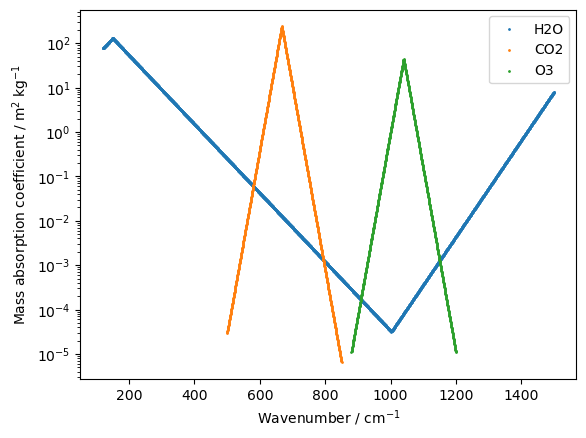

In [11]:
wn = np.arange(120,1500,0.5)

plt.scatter(wn, h2o_abs_coef_nu(wn), label = 'H2O', s = 1)
plt.scatter(wn, co2_abs_coef_nu(wn), label = 'CO2', s = 1)
plt.scatter(wn, o3_abs_coef_nu(wn), label = 'O3', s = 1)

plt.yscale('log')
plt.xlabel("Wavenumber / cm$^{-1}$")
plt.ylabel("Mass absorption coefficient / m$^2$ kg$^{-1}$")
plt.legend()

Optical depth $\tau$, can be calculated as: mass x mass absroption coeffcient of the species <br>
Transmissivity = $e^{-\tau}$ 

In [12]:
m_h2o = column_mass_h2o(288.) # typical surface temperature
m_co2 =  column_mass_co2(280.e-6) # pre-industrial levels of CO2 
m_o3  = column_mass_o3()

print(f"""
      Column integrated mass (kg)
      H2O : {m_h2o:.2f}
      CO2 : {m_co2:.2f}
      O3  : {m_o3:.2f}
      """ )


      Column integrated mass (kg)
      H2O : 26.07
      CO2 : 5.71
      O3  : 6.50
      


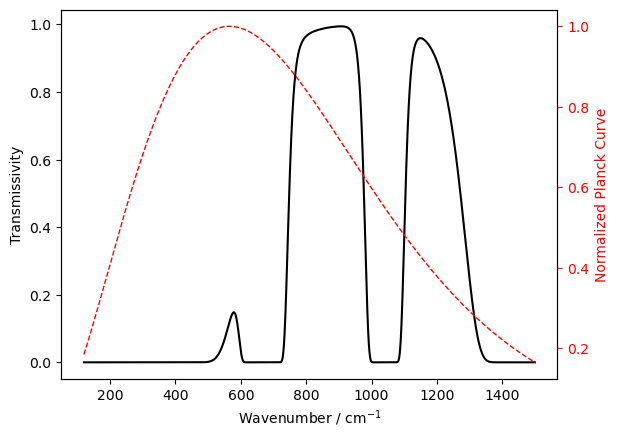

In [13]:
trans = np.exp(-(h2o_abs_coef_nu(wn)*m_h2o + co2_abs_coef_nu(wn)*m_co2 + o3_abs_coef_nu(wn)*m_o3))

plt.plot(wn, trans, color = "k")

plt.xlabel("Wavenumber / cm$^{-1}$")
plt.ylabel("Transmissivity")

ax2 = plt.twinx()
B = planck_nu(wn, T=288.)
ax2.plot(wn, B/max(B), label="Normalized Planck curve", color="r", ls = "dashed", lw = 1 ,zorder=1)
# ax2.legend(loc = "upper left", frameon=False)

# Set the label for the secondary y-axis
ax2.set_ylabel("Normalized Planck Curve", color="r")

# Set the tick colors for the secondary y-axis to red
ax2.tick_params(axis='y', colors='r')

The net transmissivity across the longwave can be calculated by numerically integrating the transmissivities weighted by the planck function.

In [14]:
atm_transmissivity = np.trapezoid(trans * B, wn) / np.trapezoid(B, wn)

print(f"Net Transmnissivity = {atm_transmissivity:0.2f}")

Net Transmnissivity = 0.28


# Example experiments
Do not yet work so well quantitatively :)

## Let us estimate 2x CO2 forcing

i.e., the change in the net outgoing longwave radiation upon doubling the CO2 concentraion

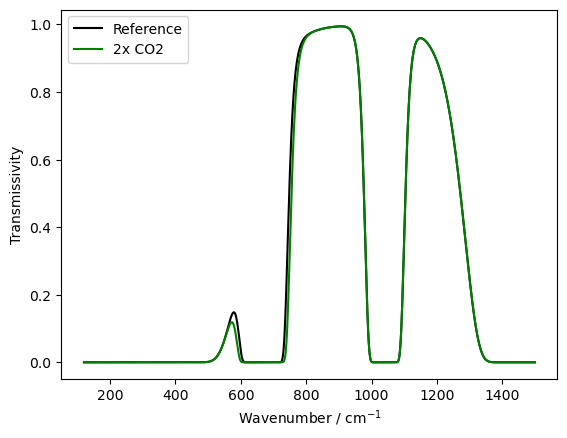

In [15]:
trans_2xco2 = np.exp(-(h2o_abs_coef_nu(wn)*m_h2o + co2_abs_coef_nu(wn)*2*m_co2 + o3_abs_coef_nu(wn)*m_o3))

plt.plot(wn, trans, color = "k", label = "Reference")
plt.plot(wn, trans_2xco2, color = "g", label = "2x CO2")

plt.xlabel("Wavenumber / cm$^{-1}$")
plt.ylabel("Transmissivity")
plt.legend();

In [16]:
atm_transmissivity_2xco2 = np.trapezoid(trans_2xco2 * B, wn) / np.trapezoid(B, wn)
# atm_transmissivity_2xco2 = 0.274
print(f"""
Net Transmnissivity         = {atm_transmissivity:0.3f}
Net Transmnissivity 2x CO2  = {atm_transmissivity_2xco2:0.3f}
""")

TS = 288.

olr_ref = outgoing_longwave_rad(TS = TS,TRANS= atm_transmissivity)
olr_2x =  outgoing_longwave_rad(TS = TS, TRANS= atm_transmissivity_2xco2)

print(f"2x CO2 Forcing = { olr_ref - olr_2x:.2f} W/ m2")


Net Transmnissivity         = 0.277
Net Transmnissivity 2x CO2  = 0.268

2x CO2 Forcing = 1.65 W/ m2


## An estimate of Equilibrium Climate Sensitivity

ECS  = 0.6 K


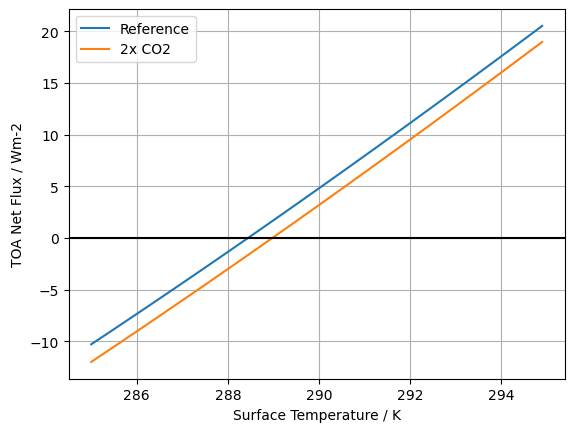

In [17]:
nus = np.linspace(10,2000,1000)
TSs = np.arange(285,295,0.1)
INCOMING = S0 * ( 1 - ALPHA )

m_co2 =  column_mass_co2(280.e-6)

olr_ref  = np.zeros(TSs.shape)
olr_2x   = np.zeros(TSs.shape)

for i, TS in enumerate(TSs):
    m_h2o = column_mass_h2o(TS)
    B = planck_nu(wn, T=TS)

    trans = np.exp(-(h2o_abs_coef_nu(wn)*m_h2o + co2_abs_coef_nu(wn)*m_co2 + o3_abs_coef_nu(wn)* m_o3))
    trans_2xco2 = np.exp(-(h2o_abs_coef_nu(wn)*m_h2o + co2_abs_coef_nu(wn)*2*m_co2 + o3_abs_coef_nu(wn)* m_o3))

    atm_transmissivity = np.trapezoid(trans * B, wn) / np.trapezoid(B, wn)
    atm_transmissivity_2xco2 = np.trapezoid(trans_2xco2 * B, wn) / np.trapezoid(B, wn)

    olr_ref[i]  += outgoing_longwave_rad(TS = TS, TRANS= atm_transmissivity)
    olr_2x[i]   += outgoing_longwave_rad(TS = TS, TRANS= atm_transmissivity_2xco2)


plt.plot(TSs, olr_ref - INCOMING, label = "Reference")
plt.plot(TSs, olr_2x - INCOMING, label = "2x CO2")

plt.axhline(0 , color = 'k')
plt.xlabel("Surface Temperature / K")
plt.ylabel("TOA Net Flux / Wm-2")

plt.legend()
plt.grid()


ecs = TSs[np.argmin(np.abs(INCOMING - olr_2x))] - TSs[np.argmin(np.abs(INCOMING - olr_ref))]
print(f"ECS  = {ecs :.1f} K")